In [ ]:
pip install finta

In [ ]:
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from sklearn import metrics
from google.colab import drive

In [ ]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/indexProcessed1.csv')

         Date         open         high  ...        close    Adj Close  volume
0  23-01-1995  7243.100098  7243.100098  ...  6967.899902  6967.899902       0
1  24-01-1995  6970.600098  7035.799805  ...  7022.899902  7022.899902       0
2  25-01-1995  7034.299805  7252.299805  ...  7240.700195  7240.700195       0
3  26-01-1995  7275.299805  7371.799805  ...  7310.500000  7310.500000       0
4  27-01-1995  7300.700195  7349.500000  ...  7297.100098  7297.100098       0

[5 rows x 7 columns]


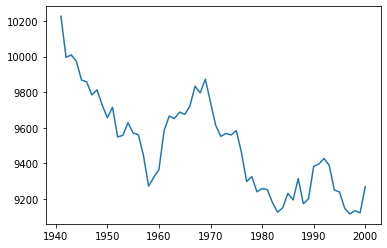

In [ ]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

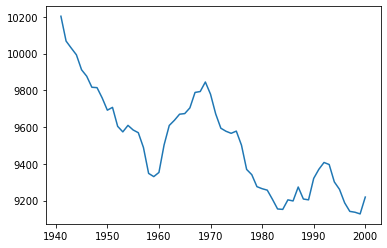

In [ ]:
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [ ]:
live_pred_data = data.iloc[-16:-11]

In [ ]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
1981,27.721610,-104.491209,-64.845034,9.098600,7.684424e+09,106.034080,-415.181000,28.469218,-5.978234,-5.942742e+09,-141.554136,-19.887325,1.217436,0.602702,0.949426,0.964473,0.969117,0.982544,0.923227,0.0
1982,25.728408,-114.810235,-74.838074,4.917285,7.644022e+09,107.556081,-386.820722,21.335689,-5.847209,-6.099555e+09,-134.589447,-22.514413,1.263692,0.561418,0.945358,0.961071,0.966236,0.980983,0.931518,0.0
1983,23.776746,-125.791428,-85.028745,4.505757,7.592468e+09,108.303695,-422.894821,12.905793,-5.351614,-6.278935e+09,-130.446521,-25.405575,1.323195,0.510272,0.941054,0.957503,0.963228,0.979388,1.054051,0.0
1984,23.691234,-133.147194,-94.652435,9.137116,7.652264e+09,107.932078,-414.084086,13.146066,-4.605563,-6.441330e+09,-118.857659,-25.490215,1.328780,0.518058,0.941908,0.959122,0.965365,0.982555,0.961585,0.0
1985,29.760407,-133.248114,-102.371571,20.984613,7.772411e+09,105.690419,-374.093786,19.717515,-3.897349,-6.289834e+09,-93.652455,-20.078668,1.271955,0.598556,0.948236,0.966124,0.972736,0.990091,0.912710,1.0


In [ ]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    

In [ ]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
    
    

In [ ]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    


In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break

In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)


In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 100 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 400 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        #print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
    
cross_Validation(data)

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.57      0.97      0.72        65
         1.0       0.50      0.04      0.07        50

    accuracy                           0.57       115
   macro avg       0.53      0.50      0.39       115
weighted avg       0.54      0.57      0.44       115

[[63  2]
 [48  2]]
{'n_neighbors': 9}
              precision    recall  f1-score   support

         0.0       1.00      0.28      0.43        65
         1.0       0.52      1.00      0.68        50

    accuracy                           0.59       115
   macro avg       0.76      0.64      0.56       115
weighted avg       0.79      0.59      0.54       115

[[18 47]
 [ 0 50]]
0.6434782608695652
              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76        65
         1.0       1.00      0.18      0.31        50

    accuracy                           0.64       115
   macro avg       0.81      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5176470588235295
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.68        44
         1.0       0.00      0.00      0.00        41

    accuracy                           0.52        85
   macro avg       0.26      0.50      0.34        85
weighted avg       0.27      0.52      0.35        85

[[44  0]
 [41  0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.52      0.31      0.39        42
         1.0       0.03      0.08      0.05        13

    accuracy                           0.25        55
   macro avg       0.28      0.19      0.22        55
weighted avg       0.40      0.25      0.31        55

[[13 29]
 [12  1]]
{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        42
         1.0       0.24      1.00      0.38        13

    accuracy                           0.24        55
   macro avg       0.12      0.50      0.19        55
weighted avg       0.06      0.24      0.09        55

[[ 0 42]
 [ 0 13]]
0.3090909090909091


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.57      0.38      0.46        42
         1.0       0.04      0.08      0.05        13

    accuracy                           0.31        55
   macro avg       0.30      0.23      0.25        55
weighted avg       0.45      0.31      0.36        55

[[16 26]
 [12  1]]
rf prediction is  [1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1

In [ ]:
live_pred_data.head()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
1985,9204.162262,29.760407,-133.248114,-102.371571,20.984613,7.772411e+09,105.690419,-374.093786,19.717515,-3.897349,-6.289834e+09,-93.652455,-20.078668,1.271955,0.598556,0.948236,0.966124,0.972736,0.990091,0.912710
1986,9198.148393,29.468263,-132.288423,-108.354941,20.844765,7.767497e+09,105.870137,-303.630969,27.476734,-3.848305,-6.473989e+09,-78.304605,-14.696220,1.173874,0.683051,0.948591,0.967009,0.973912,0.991188,1.089584
1987,9274.037192,37.769936,-123.975162,-111.478985,35.995490,7.864921e+09,112.701692,-95.721034,34.728214,-3.176140,-6.296850e+09,-58.020109,-12.325600,1.116615,0.714120,0.957235,0.976097,0.983131,0.999471,1.039741
1988,9208.642314,34.050668,-121.265785,-113.436345,23.205062,7.837793e+09,115.822127,-132.412811,34.661317,-3.085075,-6.477312e+09,-62.417762,-11.336009,1.112655,0.754682,0.951409,0.970572,0.977750,0.993679,1.048890
1989,9204.168658,33.805423,-118.117981,-114.372672,23.093704,7.782903e+09,115.501473,-71.714161,28.185163,-1.767277,-6.623085e+09,-58.420341,-11.839253,1.134785,0.761976,0.951862,0.971421,0.978758,0.994323,0.869404
